In [ ]:

from mnist_src.dataset import MNIST
import torch 
from torch import nn 
import os
#from adopt import ADOPT
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

DEVICE='cuda' if torch.cuda.is_available() else 'cpu' 

dataset=MNIST() 

In [ ]:

import os
import torch
from torchvision import datasets, transforms

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def split_and_save(dataset, output_dir):
    create_dir(output_dir)

    label_data = {label: [] for label in range(10)}


    for image, label in dataset:
        label_data[label].append((image, label))

    for label, data in label_data.items():
        images, labels = zip(*data)  
        label_tensor = torch.stack(images)  
        label_labels = torch.tensor(labels) 
        file_path = os.path.join(output_dir, f"label_{label}.pt")
        torch.save((label_tensor, label_labels), file_path)

    print(f"Dataset successfully split and saved in {output_dir}")

output_dir = "./mnist_split"

split_and_save(dataset, output_dir)

Dataset successfully split and saved in ./mnist_split


In [ ]:
def load_label_data(labels, output_dir):
    images, all_labels = [], []
    for label in labels:
        file_path = os.path.join(output_dir, f"label_{label}.pt")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File for label {label} not found in {output_dir}")
        label_images, label_labels = torch.load(file_path)
        images.append(label_images)
        all_labels.append(label_labels)

    combined_images = torch.cat(images)
    combined_labels = torch.cat(all_labels)
    return combined_images, combined_labels

labels_to_load = list(range(10))
images, labels = load_label_data(labels_to_load, output_dir)
print(f"Loaded data for labels {labels_to_load} with shapes: images={images.shape}, labels={labels.shape}")

Loaded data for labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with shapes: images=torch.Size([60000, 1, 28, 28]), labels=torch.Size([60000])


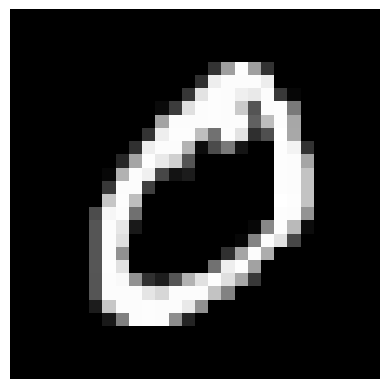

In [4]:
plt.imshow(images[0].squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def create_new_dataset(images, labels):
    return TensorDataset(images, labels)

In [6]:
new_dataset = create_new_dataset(images, labels)
print(f"New dataset created with {len(new_dataset)} samples.")

New dataset created with 60000 samples.


all the same shape torch.Size([1000])


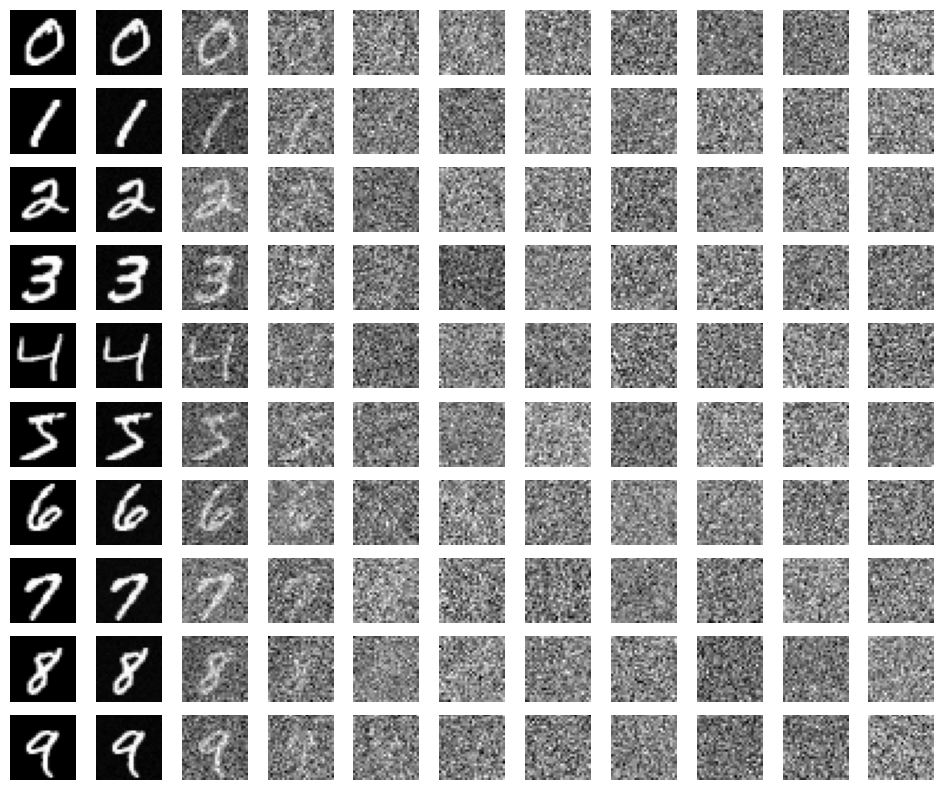

q_x(x_0,t) is ok


In [ ]:

images = []
for i in range(10):
    for imag, label in new_dataset:

        if label == i:
            images.append(imag)
            break


num_steps = 1000            

betas=torch.linspace(0.0001,0.02,num_steps)

alphas = 1-betas			
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)  
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape
print("all the same shape", betas.shape)	

def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise) 

fig, axes = plt.subplots(10, 11, figsize=(12, 10))
for i in range(10):
    x_0 = images[i].unsqueeze(0)
    x_t = x_0
    axes[i, 0].imshow(x_t.squeeze().cpu().numpy(), cmap='gray')
    axes[i, 0].axis('off')
    for t in range(1, 11):
        x_t = q_x(x_t, (t-1)*100)
        axes[i, t].imshow(x_t.squeeze().cpu().numpy(), cmap='gray')
        axes[i, t].axis('off')
plt.show()
print("q_x(x_0,t) is ok")
    

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
from Flow_Perturbation.src.GMM_distribution import get_energy_device,sample_NWell,redraw_samples,get_energy_gradient_device
from Flow_Perturbation.src.DDPM import calc_alphas_betas, diffusion_loss_fn, diffusion_loss_fn_v_prediction
from Flow_Perturbation.src.train import train_model_DDPM
from Flow_Perturbation.src.DDPM import interpolate_parameters,DDPMSamplerCoM, DDPMSampler
from Flow_Perturbation.src.utils import  generate_tsampling, modify_samples_torch_batched_K,generate_betasampling
from Flow_Perturbation.src.SMC import generate_doubling_intervals_exclude_start,systematic_resampling,find_closest_larger_element_desc,mc_step,resample_if_needed

In [9]:
rcParams.update({'font.size': 16})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
num_steps = 1000
alphas, betas, alphas_prod, alphas_bar_sqrt, one_minus_alphas_bar_sqrt = calc_alphas_betas(num_steps=num_steps, scaling=6, beta_min=1e-5, beta_max=1e-2)

In [16]:
from torchcfm.models.unet.unet import UNetModelWrapper2

In [17]:
EPOCH=500
BATCH_SIZE=300

dataloader=DataLoader(new_dataset,batch_size=BATCH_SIZE,shuffle=True)    # 数据加载器
model=UNetModelWrapper2(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=(1, 2, 2),
    num_heads=4,
    num_head_channels=32,
    attention_resolutions="16",
    dropout=0.1,
    class_cond=True,
    num_classes=10,
).to(device)
model.train()


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [18]:

path = 'models/MNIST0-9-128'
model.load_state_dict(torch.load(f'{path}/model.pth', map_location=device))
#model = train_model_DDPM(model, dataloader, path, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps,num_epoch=EPOCH,lr=1e-3, loss_DDPM = diffusion_loss_fn,decay_steps = EPOCH//50)
print('Training done!')
model.eval()

Training done!


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
if_v = False

In [21]:
import torch
import numpy as np
from scipy.interpolate import CubicSpline
import torch.nn.functional as F
from Flow_Perturbation.src.odesolver import odesolver,odesolver_Huch_dSt


class DDPMSampler:
    def __init__(self, model, st, st_derivative, sigma_t_derivative,at,oat,if_v =False, device = 'cuda:0'):
        self.model = model
        self.st = st
        self.st_derivative = st_derivative
        self.sigma_t_derivative = sigma_t_derivative
        self.at = at
        self.oat = oat
        self.device = device
        self.if_v = if_v

    def score_function(self, x, y, t):
        '''
        Computes the score function for input data x at given time step t.

        The score function is a key concept in generative models, guiding the reverse process of data through a noise process.

        Parameters:
        - x (Tensor): The input data, typically noisy data at a certain time step t.
        - t (Tensor): A scalar or a tensor with the same batch size as x, representing the time step.

        Returns:
        - Tensor: The score function value for the input data x at time step t.
        '''
        # Expand the time step t to match the batch size of x and ensure it's on the correct device
        #print(t.shape,x.shape,y.shape)
        t_repeat = (t * torch.ones(x.shape[0])).to(self.device)
        if self.if_v:
            # use the model to predict \( v_\theta(x_t, t) \)
            pred_velocity = self.model(x, t_repeat, y)
            
            # from \( v_\theta \) derive \( x_0 \)
            sqrt_alpha = torch.tensor(self.at(t))  # \( \sqrt{\alpha_t} \)
            sqrt_one_minus_alpha = torch.tensor(self.oat(t))  # \( \sqrt{1 - \alpha_t} \)
            #x_0 = (x - sqrt_one_minus_alpha * pred_velocity) / sqrt_alpha

            # Predict the noise for the noisy data at the given time step
            pred_noise = sqrt_alpha * pred_velocity + sqrt_one_minus_alpha * x
        else:
            # Use the model to predict the noise for the noisy data at the given time step
            pred_noise = self.model(x, t_repeat, y)
        # Calculate the value of the score function
        return self.st_derivative(t) / self.st(t) * x + self.st(t) * self.sigma_t_derivative(t) * pred_noise
    
    def score_function_rearange(self, t, x, y):
        return self.score_function(x, y, t)
    
    def score_function_1element(self, x, y, t):
        x = x.reshape(-1,x.shape[-1])
        score = self.score_function(x, y, t)
        return score.flatten()
    
    @torch.no_grad()
    def ode_step(self, x, y, t, t_next):
        function = lambda t, x: self.score_function_rearange(t, x, y)
        return odesolver(function, x, t, t_next)
    
    @torch.no_grad()
    def exact_dynamics(self, xT, y, timesteps, method = 'RK4'): 
        xt = xT
        function = lambda t, x: self.score_function_rearange(t, x, y)
        for i in range(len(timesteps)-1):
            t = timesteps[i]
            tnext = timesteps[i+1]
            xt = odesolver(function, xt, t, tnext, method)
            xt=torch.clamp(xt, -2.0, 2.0).detach()
        return xt

In [22]:
st, sigma_t, st_derivative, sigma_t_derivative,at,oat = interpolate_parameters(num_steps, alphas_prod,alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
Sampler = DDPMSampler(model, st, st_derivative, sigma_t_derivative,at,oat,if_v,device)

exact_dynamics = Sampler.exact_dynamics
time_forward = generate_tsampling(0, num_steps-1, 20, 4.0)
time_backward = time_forward[::-1]

In [23]:
batch_size=10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=torch.arange(start=0,end=10,dtype=torch.long).to(device)  # (5,)

In [24]:
#x0 = exact_dynamics(xT, yT, time_backward,method='Euler')
x0 = exact_dynamics(xT, yT, time_backward)

In [25]:
xT_reverse = exact_dynamics(x0, yT, time_forward)

In [26]:
xT - xT_reverse

tensor([[[[-4.4674e-03,  4.2337e-03,  1.3289e-03,  ..., -2.4207e-03,
           -9.5135e-04,  1.7363e-04],
          [ 5.1558e-03,  1.7023e-04, -2.9204e-03,  ..., -4.5450e-03,
           -1.0996e-03,  1.5284e-03],
          [-7.3031e-04, -4.0234e-03, -2.8544e-03,  ..., -3.4023e-03,
           -4.0708e-04,  8.1508e-04],
          ...,
          [-3.1738e-03, -2.7539e-03,  4.8775e-01,  ..., -6.1452e-04,
           -2.4431e-03, -1.5237e-03],
          [ 1.9317e-03, -1.2457e-04, -5.2707e-03,  ..., -1.0819e-03,
           -3.4685e-03, -7.8440e-05],
          [-1.1516e-02,  3.0893e-03, -2.8147e-03,  ..., -2.3474e-03,
           -4.7117e-03, -2.3577e-03]]],


        [[[-4.9854e-03,  8.3098e-03, -4.2157e-03,  ...,  6.7106e-04,
            5.5032e-03,  3.6349e-03],
          [-7.5150e-03,  1.3300e-03, -7.2147e-03,  ...,  2.1078e-03,
           -1.1966e-03, -1.4109e-03],
          [-2.4085e-03, -4.6253e-01, -2.6280e-03,  ..., -1.0040e-03,
           -7.8277e-03, -1.1877e-02],
          ...,
   

In [29]:
labels_to_load = list(range(10))
images, labels = load_label_data(labels_to_load, "./mnist_split")
dataset3 = create_new_dataset(images, labels)
dataloader = DataLoader(dataset3, batch_size=200, shuffle=True)

In [30]:
images = torch.tensor(images).to(device) 
labels = torch.tensor(labels).to(device)  

/tmp/ipykernel_290322/1085643470.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_290322/1085643470.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


In [31]:
data_9 = np.load('samples_0-9-full.npz')
samples_9 = data_9['samples']
labels_9 = data_9['labels']
dataset_9 = create_new_dataset(torch.tensor(samples_9, dtype=torch.float32), torch.tensor(labels_9, dtype=torch.int64))
dataloader_9 = DataLoader(dataset_9, batch_size=300, shuffle=True)
print(f"Loaded data now with shapes: samples={samples_9.shape}, labels={labels_9.shape}")

Loaded data now with shapes: samples=(50000, 1, 28, 28), labels=(50000,)


In [32]:
samples_9 = torch.tensor(samples_9, dtype=torch.float32).to(device)
labels_9 = torch.tensor(labels_9, dtype=torch.long).to(device)

In [35]:
import math

In [36]:
import torch
import numpy as np

def sample_t(batch_size, weighting="lognormal", path_type="linear", device="cuda", dtype=torch.float32):
    """
    根据 weighting 和 path_type 生成 t ∈ (0,1)

    Args:
        batch_size (int): 样本数量
        weighting (str): "uniform" 或 "lognormal"
        path_type (str): "linear" 或 "cosine"（仅 lognormal 有效）
        device (str/torch.device): 张量存放设备
        dtype (torch.dtype): 数据类型

    Returns:
        torch.Tensor: 形状 [batch_size, 1, 1, 1] 的 t
    """
    if weighting not in ["uniform", "lognormal"]:
        raise ValueError(f"Unknown weighting: {weighting}")
    if path_type not in ["linear", "cosine"]:
        raise ValueError(f"Unknown path_type: {path_type}")

    if weighting == "uniform":
        t = torch.rand((batch_size, 1), device=device, dtype=dtype)

    elif weighting == "lognormal":
        # 先采样 lognormal 分布的 sigma
        rnd_normal = torch.randn((batch_size, 1), device=device, dtype=dtype)
        sigma = rnd_normal.exp()

        if path_type == "linear":
            t = sigma / (1 + sigma)
        elif path_type == "cosine":
            t = 2 / np.pi * torch.atan(sigma)

    return t

In [ ]:
def sample_z_per_label_random(x, y, samples, labels):

    device = samples.device
    x = x.to(device)
    y = y.to(device)
    labels = labels.to(device)

    batch_size = x.shape[0]
    z = torch.empty((batch_size, *samples.shape[1:]), dtype=samples.dtype, device=device)


    unique_labels = y.unique()
    label_to_idx = {lbl.item(): torch.nonzero(labels == lbl, as_tuple=True)[0] for lbl in unique_labels}

    for lbl in unique_labels:

        batch_idxs = torch.nonzero(y == lbl, as_tuple=True)[0]

        candidate_idxs = label_to_idx[lbl.item()]

        random_idx = torch.randint(0, len(candidate_idxs), (len(batch_idxs),), device=device)
        selected_idxs = candidate_idxs[random_idx]

        z[batch_idxs] = samples[selected_idxs]

    return z


In [44]:
import random
import torchvision.transforms.functional as TF
def random_gaussian_blur_tensor(x, p=0.5, kernel_size=5, sigma=(0.1, 2.0)):
    if random.random() < p:
        s = random.uniform(*sigma)
        return TF.gaussian_blur(x, kernel_size, sigma=s)
    return x

In [45]:
from torchcfm.conditional_flow_matching import *

In [ ]:
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)

In [ ]:
def FlowMatching_loss(model, x, y,
                      device='cuda'):
    x = x.to(device)
    y = y.to(device)

    B = x.shape[0]

    z = sample_z_per_label_random(x, y, samples_9, labels_9)  # -> [B, C, H, W]
    z = random_gaussian_blur_tensor(z, p=0.3, kernel_size=5, sigma=(0.01, 0.02))
    t, x_t, u_t, _, y1 = FM.guided_sample_location_and_conditional_flow(z, x, y1=y) 

    pred_v = model(x_t, t.squeeze(-1), y1)
    return (u_t - pred_v).square().mean() 

In [48]:
model_FM=UNetModelWrapper2(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=(1, 2, 2),
    num_heads=4,
    num_head_channels=32,
    attention_resolutions="16",
    dropout=0.1,
    class_cond=True,
    num_classes=10,
).to(device)
model_FM.train()

UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [ ]:
#from adopt import ADOPT
import os
def train_model_DDPM(model, dataloader, path, num_epoch=81, lr=1e-3, 
                     loss_fn=diffusion_loss_fn, decay_steps=20, device='cuda'):
    if not os.path.exists(path):
        os.makedirs(path)
    print('Start Training...')

    #optimizer = ADOPT(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epoch):
        model.train()
        epoch_losses = []

        for batch_x, labels_x in dataloader:
            batch_x = batch_x.to(device) * 2 - 1
            y = labels_x.to(device)

            backup_state = {k: v.clone() for k, v in model.state_dict().items()}


            loss = loss_fn(model, batch_x, y)

            if torch.isnan(loss):
                model.load_state_dict(backup_state)
                for pg in optimizer.param_groups:
                    pg['lr'] *= 0.5
                    print(f"  → new lr: {pg['lr']:.2e}")
                continue


            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

        if epoch % decay_steps == 0 and len(epoch_losses) > 0:
            avg_loss = np.mean(epoch_losses)
            print(f"[Epoch {epoch}/{num_epoch}]  loss: {avg_loss:.6f}")
            tmp_path = os.path.join(path, '.model.pth')
            torch.save(model.state_dict(), tmp_path)
            os.replace(tmp_path, os.path.join(path, 'model.pth'))

    final_path = os.path.join(path, 'model.pth')
    torch.save(model.state_dict(), final_path)
    print("Training Finished. Model saved to", final_path)

    return model

In [50]:
# 37min
path = 'FM1210/mnist_3.2'
model_FM.load_state_dict(torch.load(f'{path}/model.pth', map_location=device))
#model_FM = train_model_DDPM(model_FM, dataloader, path, num_epoch=50,lr=1e-4, loss_fn = FlowMatching_loss,decay_steps = EPOCH//50)
print('Training done!')
model_FM.eval()

Training done!


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [51]:
for param in model_FM.parameters():
    param.requires_grad = False

In [ ]:
class FMSampler:
    def __init__(self, model, device = 'cuda:0'):
        self.model = model
        self.device = device

    def score_function(self, x, y, t):
        '''
        Computes the score function for input data x at given time step t.

        The score function is a key concept in generative models, guiding the reverse process of data through a noise process.

        Parameters:
        - x (Tensor): The input data, typically noisy data at a certain time step t.
        - t (Tensor): A scalar or a tensor with the same batch size as x, representing the time step.

        Returns:
        - Tensor: The score function value for the input data x at time step t.
        '''
        # Expand the time step t to match the batch size of x and ensure it's on the correct device
        #print(t.shape,x.shape,y.shape)
        t_repeat = (t * torch.ones(x.shape[0])).to(self.device)
        pred_noise = self.model(x, t_repeat, y)
        # Calculate the value of the score function
        return pred_noise
    
    def score_function_rearange(self, t, x, y):
        return self.score_function(x, y, t)
    
    def score_function_1element(self, x, y, t):
        x = x.reshape(-1,x.shape[-1])
        score = self.score_function(x, y, t)
        return score.flatten()
    
    @torch.no_grad()
    def ode_step(self, x, y, t, t_next):
        function = lambda t, x: self.score_function_rearange(t, x, y)
        return odesolver(function, x, t, t_next)
    
    @torch.no_grad()
    def exact_dynamics(self, xT, y, timesteps, method = 'RK4'): 
        xt = xT
        function = lambda t, x: self.score_function_rearange(t, x, y)
        for i in range(len(timesteps)-1):
            t = timesteps[i]
            tnext = timesteps[i+1]
            xt = odesolver(function, xt, t, tnext, method)
        xt=torch.clamp(xt, -1.0, 1.0).detach()
        return xt

In [53]:
num_steps = 30
Sampler_FM =FMSampler(model_FM,device)

exact_dynamics_FM = Sampler_FM.exact_dynamics
time_forward_FM = torch.flip(torch.linspace(0, 1, 2), dims=[0])
time_backward_FM = torch.flip(time_forward_FM, dims=[0])

In [54]:
batch_size = 10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=9*torch.ones(size=(batch_size,),dtype=torch.long).to(device)  # (5,)

In [55]:
x1 = exact_dynamics(xT, yT, time_backward)

In [56]:
x0 = exact_dynamics_FM(x1, yT, time_backward_FM)

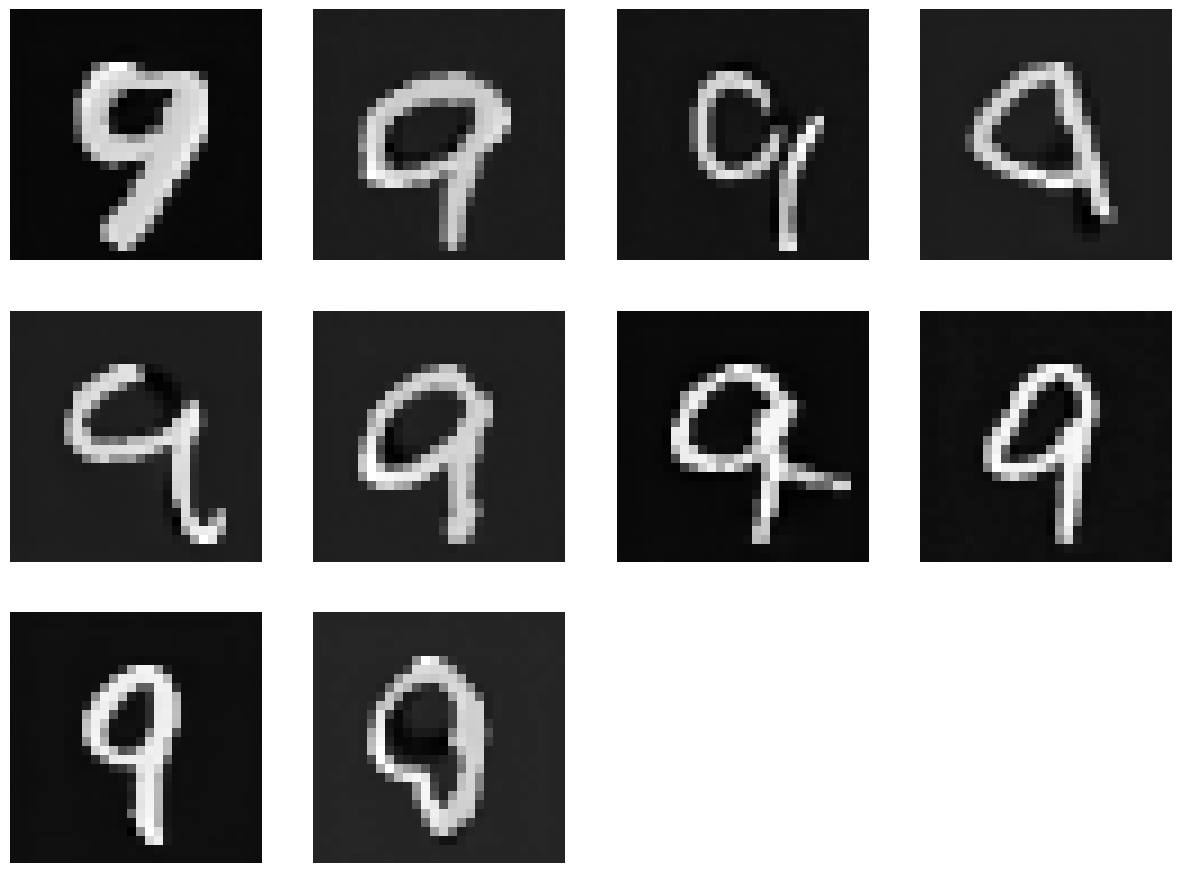

In [57]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x0[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [58]:
batch_size = 10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=torch.arange(start=0,end=10,dtype=torch.long).to(device)  # (5,)

In [59]:
x1 = exact_dynamics(xT, yT, time_backward)

In [61]:
x0 = exact_dynamics_FM(x1, yT, time_backward_FM)

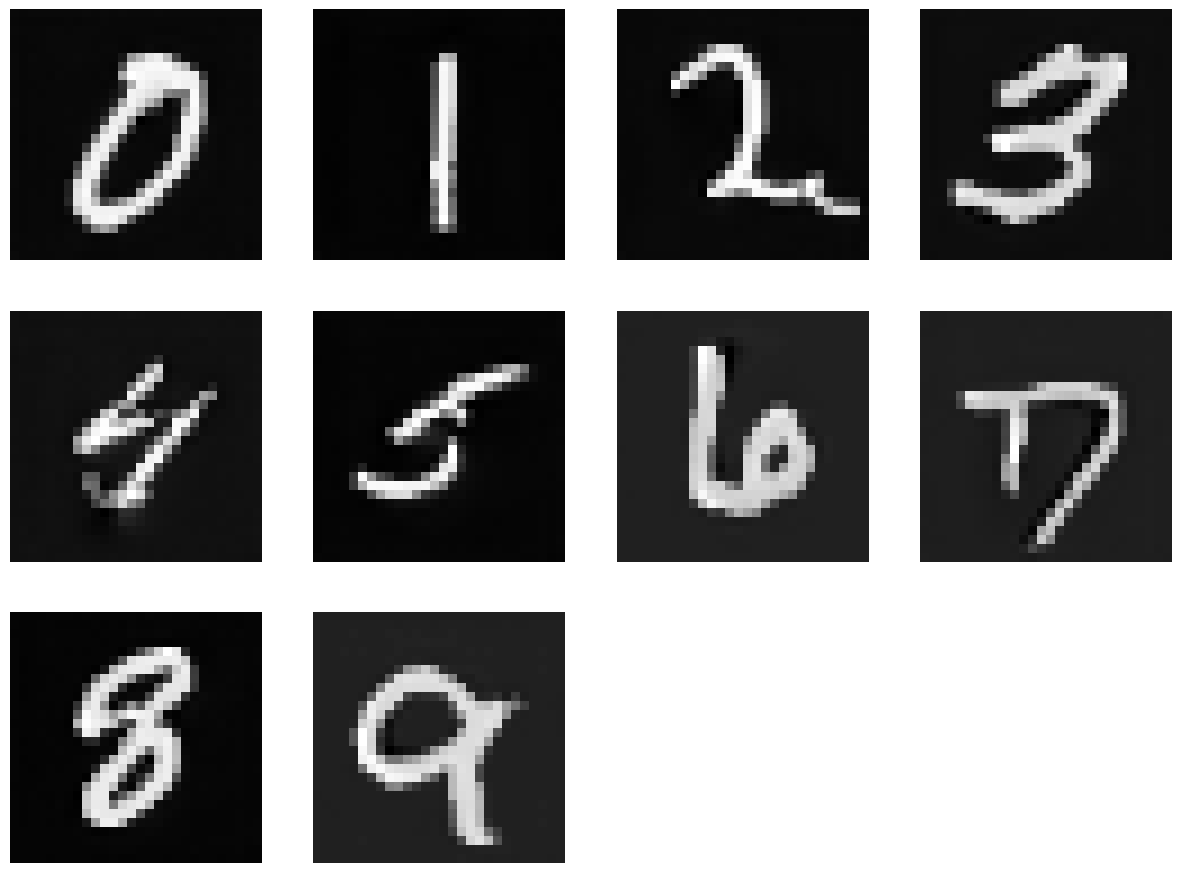

In [62]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x0[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

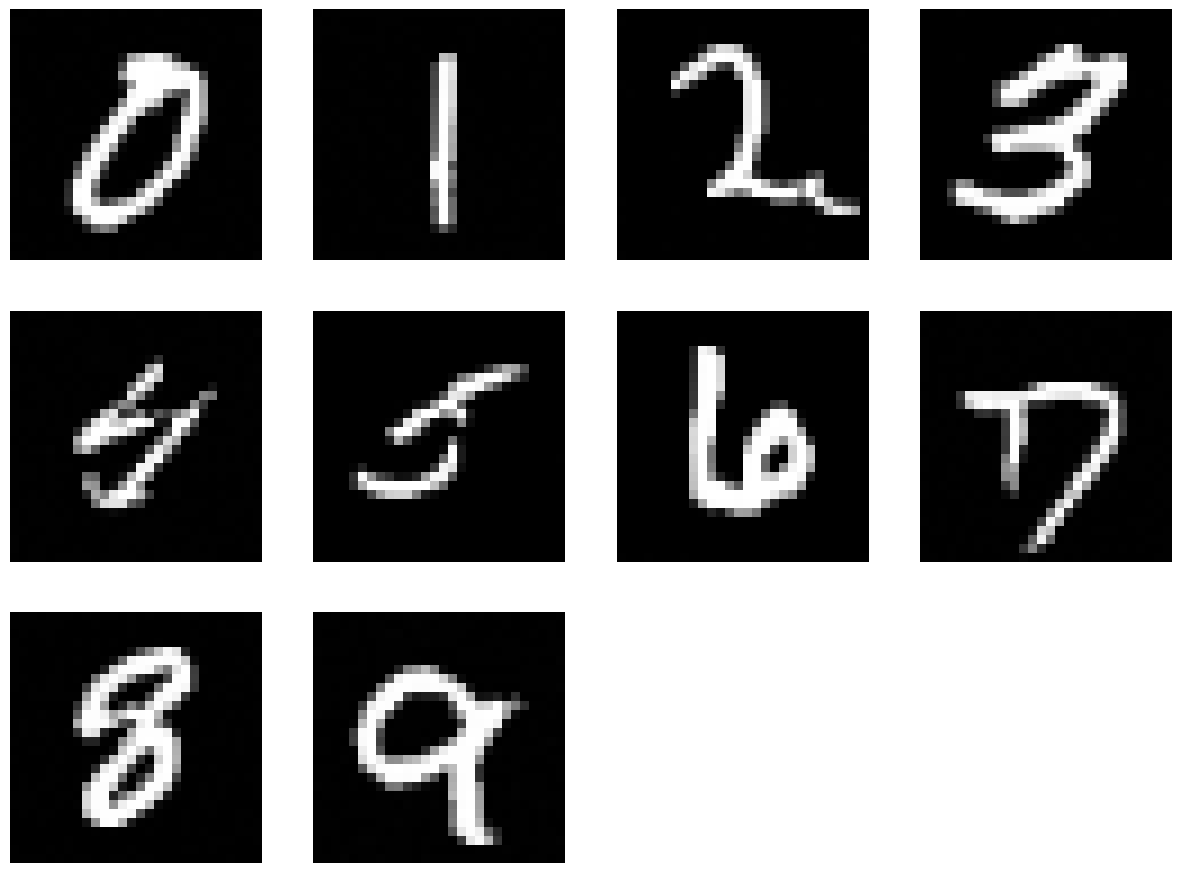

In [63]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x1[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# 分批次采样，采样10w个，保存成.npz
from tqdm import tqdm
batch_size = 500
num_samples = 50000
samples_init = []
samples = []
labels = []
for i in tqdm(range(num_samples // batch_size)):
    xT = 1.0*torch.randn(size=(batch_size, 1, 28, 28)).to(device)  # (10000,1,28,28)
    yT= torch.arange(start=0, end=10, dtype=torch.long).to(device)  # (10000,)
    yT = yT.repeat(batch_size // 10)  
    x1 = exact_dynamics(xT, yT, time_backward)
    x0 = exact_dynamics_FM(x1, yT, time_backward_FM)
    samples.append(x0.cpu().detach().numpy())
    samples_init.append(x1.cpu().detach().numpy())
    labels.append(yT.cpu().detach().numpy())
samples = np.concatenate(samples, axis=0)
samples_init = np.concatenate(samples_init, axis=0)
labels = np.concatenate(labels, axis=0)
np.savez('samples_0-9-DFR1.npz', samples=samples, labels=labels)
#np.savez('samples_0-9-full.npz', samples=samples_init, labels=labels)

100%|██████████| 100/100 [23:25<00:00, 14.05s/it]


In [66]:
immages_data = np.concatenate([images.cpu().numpy(), images.cpu().numpy(), images.cpu().numpy()], axis=1)

In [ ]:
samples_9 = (samples+1) / 2  
samples_9 = samples_9.clip(0, 1)  

In [68]:
samples_9 = np.concatenate([samples_9, samples_9, samples_9], axis=1)

In [74]:
immages_data = np.transpose(immages_data, (0, 2, 3, 1))
samples_9 = np.transpose(samples_9, (0, 2, 3, 1))

In [ ]:
import torch
from torch.utils.data import Dataset

class NumpyDatasetUInt8(Dataset):
    def __init__(self, data):
        if data.dtype != np.uint8:
            data = np.clip(data, 0, 1)  
            data = (data * 255).astype(np.uint8)
        self.data = torch.from_numpy(data)
        if self.data.ndim == 4 and self.data.shape[-1] in [1,3]:
            self.data = self.data.permute(0,3,1,2)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]



In [77]:
real_ds = NumpyDatasetUInt8(immages_data)
fake_ds = NumpyDatasetUInt8(samples_9)

from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1=fake_ds,
    input2=real_ds,
    cuda=True,
    isc=True,
    fid=True,
    kid=True,  # sFID
    batch_size=200,
    verbose=True
)



Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Processing samples                                                              
Extracting features from input2
Processing samples                                                              
Inception Score: 2.1390335437600188 ± 0.014527279097938287
Frechet Inception Distance: 2.3791206749991147
Kernel Inception Distance: 0.0015346975425425359 ± 0.00035530172140167004       


In [78]:
print("FID  :", metrics['frechet_inception_distance'])
print("sFID :", metrics['kernel_inception_distance_mean'])
print("IS   :", metrics['inception_score_mean'])


FID  : 2.3791206749991147
sFID : 0.0015346975425425359
IS   : 2.1390335437600188


In [79]:
samples_init = np.concatenate([samples_init, samples_init, samples_init], axis=1)

In [ ]:
samples_init = (samples_init+1) / 2  
samples_init = samples_init.clip(0, 1)  

In [81]:
samples_init.shape

(50000, 3, 28, 28)

In [84]:
samples_init = np.transpose(samples_init, (0, 2, 3, 1))

In [86]:
real_ds = NumpyDatasetUInt8(immages_data)
fake_ds = NumpyDatasetUInt8(samples_init)

from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1=fake_ds,
    input2=real_ds,
    cuda=True,
    isc=True,
    fid=True,
    kid=True,  # sFID
    batch_size=200,
    verbose=True
)

print("FID  :", metrics['frechet_inception_distance'])
print("sFID :", metrics['kernel_inception_distance_mean'])
print("IS   :", metrics['inception_score_mean'])


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Processing samples                                                              
Extracting features from input2
Processing samples                                                              
Inception Score: 2.0775585275153863 ± 0.014768950695925721
Frechet Inception Distance: 3.955477637607828
Kernel Inception Distance: 0.003631234489489472 ± 0.0005176980017622429         


FID  : 3.955477637607828
sFID : 0.003631234489489472
IS   : 2.0775585275153863
